# Proyecto 3 - Minería de datos
***Universidad del Valle de Guatemala***

___4 de marzo, 2025___

[link del repositorio](https://github.com/DanielRasho/MD-Proyecto3)

**Autores:**
- Daniel Alfredo Rayo Roldán
- Gerardo Pineda
- Juan Luis

# Introducción
De acuerdo a *Herre, Samborska & Roser* (2025) varios medios parecen indicar que la cantidad de divorcios que ocurre cada año ha estado creciendo con los años, de hecho, según el Registro Nacional de Personas en Guatemala (2024) la cantidad de matrimonios disminuyeron y los divorcios aumentaron en 2024. Sin embargo se falla en realizar estos datos a nivel historico y entre diferentes países, dado que las variaciones son muy marcadas entre diferentes países, habiendo países cuya tasa de divorcios ha disminuido versus, otros que siguen en aument como paises bajos (Herre, Samborska & Rose, 2025). Este proyecto sera un intento en poder predecir que parejas se divorcian y las tendencias historicas en Guatemala.

# Situación Problemática

Durante la última década (2013–2023), se ha evidenciado una tendencia creciente en el número de divorcios registrados en Guatemala. Esta alza, especialmente notoria tras la disminución temporal en 2020 atribuida a la pandemia, ha generado inquietudes sobre los factores que impulsan la disolución de los matrimonios.

Diversos elementos sociodemográficos como la edad de los cónyuges, su nivel educativo, y las ocupaciones que desempeñan, parecen jugar un papel relevante en esta problemática. En particular, se ha observado que los matrimonios entre personas jóvenes podrían estar enfrentando mayores tasas de separación, lo cual sugiere una transformación en las dinámicas familiares y sociales del país.

Frente a esta realidad, se vuelve urgente estudiar estos patrones con un enfoque predictivo, de manera que se puedan anticipar tendencias futuras en el número de divorcios.

## Objetivos Generales

Usando los datos del INE (Instituto nacional de Guatemala) entre 2013 a 2020 sobre divorcios y matrimonios en Guatemala, se plantea: 

- Entrener un modelo que pueda predecir que parejas son propensas a divorciarse.
- Predecir la cantidad de divorcios futuros para los próximos 5 años.

## Objetivos Específicos
1. Determinar si el comportamiento de divorcios es creciente o decreciente.
2. Determinar cual fue el comportamiento de la cantidad de divorcios antes, durante y después de pandemia.
3. Tener un indice de predicción con un *accuracy* >= 90.0%

In [182]:
import warnings
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from scipy.stats import shapiro, kstest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# Dont print warnings
warnings.simplefilter(action="ignore")

# Descripción de los datos
Se partieron de 2 sets de datos proporcionados por el INE (Instituto Nacional de Estadística) sobre matrimonios y divorcios ocurridos en Guatemala entre los años 2013 hasta 2023 (11 años) ambos contando con las mismas 19 variables. El set de divorcios comprende 76669 registros, la totalidad de los datos registrados por el INE. El set matrimonios comprende 76670, el cual es una muestra del set total, para tener un cantidad balanceada a los divorcios. **Se asumió que los todas las parejas en el conjunto de matrimonios se mantuvieron casadas durante el rango de tiempo estudiado,** es decir no hay parejas registradas en ambos datasets de matrimonios y divorcios.

Se necesitó hacer un procesamiento de los datos, dado que las disposición y nombre de las variables cambió ligeramente a lo largo de los años, diferencias que se unificaron en las siguientes variables finales, con las que se trabajó:

**Variables númericas:**

| Descripcion | Codificación | Categoría Nula |
|-----------------|-------|----|
| Edad del hombre | EDADHOM  | 999 |
| Edad de la mujer | EDADMUJ | 999 |

**Variables categóricas:**

| Descripcion | Codificación | Categoría Nula | 
|-----------------------------------|-------|---|
| Departamento de registro          | DEPREG | N/A |
| Municipio de registro             | MUPREG   |N/A | 
| Mes de registro                   | MESREG   |N/A |
| Año de registro                   | AÑOREG   |N/A |
| Día de ocurrencia                 | DIAOCU |N/A |
| Mes de ocurrencia                 | MESOCU  |N/A |
| Año de ocurrencia                 | AÑOOCU |N/A |
| Departamento de ocurrencia        | DEPOCU |N/A |
| Municipio de ocurrencia           |  MUPOCU |N/A |
| Grupo étnico del hombre           | PUEHOM | 9 |
| Grupo étnico de la mujer          | PUEMUJ | 9 |
| Nacionalidad del hombre           | NACHOM | 9999 | 
| Nacionalidad de la mujer          | NACMUJ | 9999 |
| Escolaridad del hombre            | ESCHOM | 9 | 
| Escolaridad de la mujer           | ESCMUJ | 9 |
| Ocupación del hombre              | CIUOHOM | 99 | 
| Ocupación de la mujer             | CIUOMUJ | 99 |

***Nota:*** *La "categoría nula" para las variables en las que aplica, indica ese valor reservado para observaciones "sin definir"; se podrían considerar comoun equivalente del Nan.*

***Nota:*** A partir de ahora los nombres de las variables en su versión codificada o extendida se usará indistintamente, dependiendo de cual ofrece una mayor claridad a la hora de presentar la información.

In [183]:
# Step 1: Get all CSV file paths
divorces_files = glob.glob("data/divorces/*.CSV")
marriage_files = glob.glob("data/marriages/*.csv")

# Step 2: Define a generator to read and process each file on the fly
def read_and_clean(file):
    df = pd.read_csv(file)
    return df

numerical_var = ["EDADHOM", "EDADMUJ"]
categorical_var = [
    "DEPREG",
    "MUPREG",
    "MESREG",
    "AÑOREG",
    "DIAOCU",
    "MESOCU",
    "AÑOOCU",
    "DEPOCU",
    "MUPOCU",
    "PUEHOM", 
    "PUEMUJ", 
    "NACHOM", 
    "NACMUJ", 
    "ESCHOM", 
    "ESCMUJ", 
    "CIUOMUJ", 
    "CIUOHOM"]

# Step 3: Merge without storing copies
divorces_df = pd.concat((read_and_clean(file) for file in divorces_files), ignore_index=True)
marriages_df = pd.concat((read_and_clean(file) for file in marriage_files), ignore_index=True)

In [184]:
# Now dictionary mappings are defined in extern script. Call the variables just as usual
%run ./dictionaries.py

<Figure size 640x480 with 0 Axes>

## Tratamiento de las variables
Con la base de datos preparada, se procedio a inspeccionar los datasets, para verificar si necesitaban un tratamiento previo, al revisar la distribución de datos nulos.

**Datos nulos para datos de divorcios**

In [185]:
df_null_values = divorces_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]
null_values = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "NACHOM": 9999,
    "NACMUJ": 9999,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(divorces_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
null_counts_df['Variable'] = null_counts_df['Variable'].map(VARS)
total_rows = len(divorces_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,Edad hombre,34573,45.1
1,Edad mujer,34521,45.0
2,Pueblo étnico del hombre,37606,49.0
3,Pueblo étnico de la mujer,37726,49.2
4,Nacionalidad hombre,298,0.4
5,Nacionalidad mujer,306,0.4
6,Escolaridad del hombre,33234,43.3
7,Escolaridad de la mujer,32856,42.9
8,Ocupación de la mujer,23712,30.9
9,Ocupación de la mujer,19831,25.9


**Datos nulos para datos de matrimonios**

In [186]:
df_null_values = marriages_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(marriages_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
null_counts_df['Variable'] = null_counts_df['Variable'].map(VARS)
total_rows = len(marriages_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,Edad hombre,13,0.0
1,Edad mujer,18,0.0
2,Pueblo étnico del hombre,5012,6.5
3,Pueblo étnico de la mujer,7076,9.2
4,Nacionalidad hombre,0,0.0
5,Nacionalidad mujer,2,0.0
6,Escolaridad del hombre,2907,3.8
7,Escolaridad de la mujer,4767,6.2
8,Ocupación de la mujer,1143,1.5
9,Ocupación de la mujer,742,1.0


Se puede observar que para los datos de divorcios todas las variables donde hay posibilidad de haber datos nulos, hay un porcentaje considerable siendo la menor *Nacionalidad* (0.4%), y la mayor la variable de *Grupo étnico* (49.2%). Por el contrario el conjunto de datos de matrimonios contuvo porcentajes no mayores al 10% de datos nulos. A continuación se explica el tratamiento que se le dio a los valores nulos.

**Tratamiento de datos nulos**

Para los datos nulos, la primera opción fue crear un modelo que predijera cuales podrían ser los valores nulos en base a los patrones que exciben las demás variables, sin embargo para ello fue primero necesario determinar que hubiera algún tipo de correlación entre las variables, para ello se elaboró las matrices de correlación siguientes.

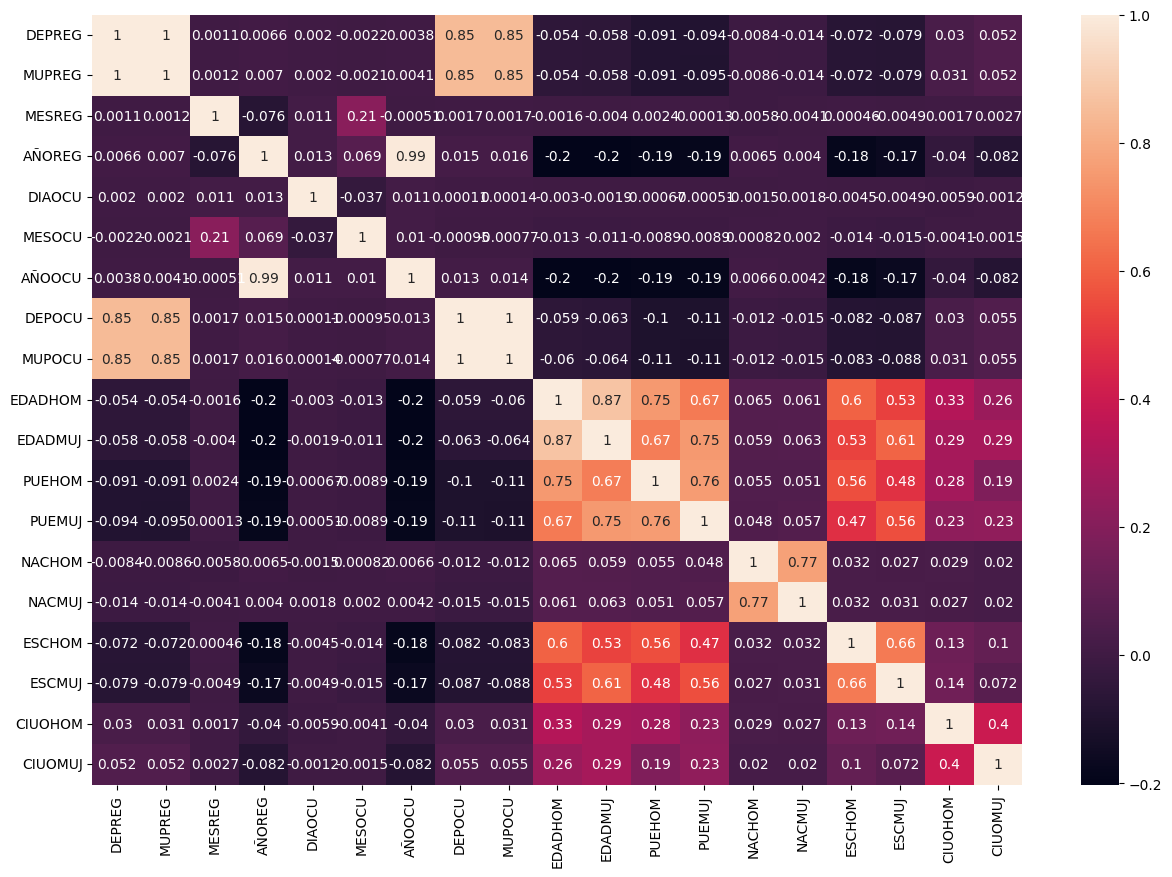

In [187]:
# 2. 
corr = divorces_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

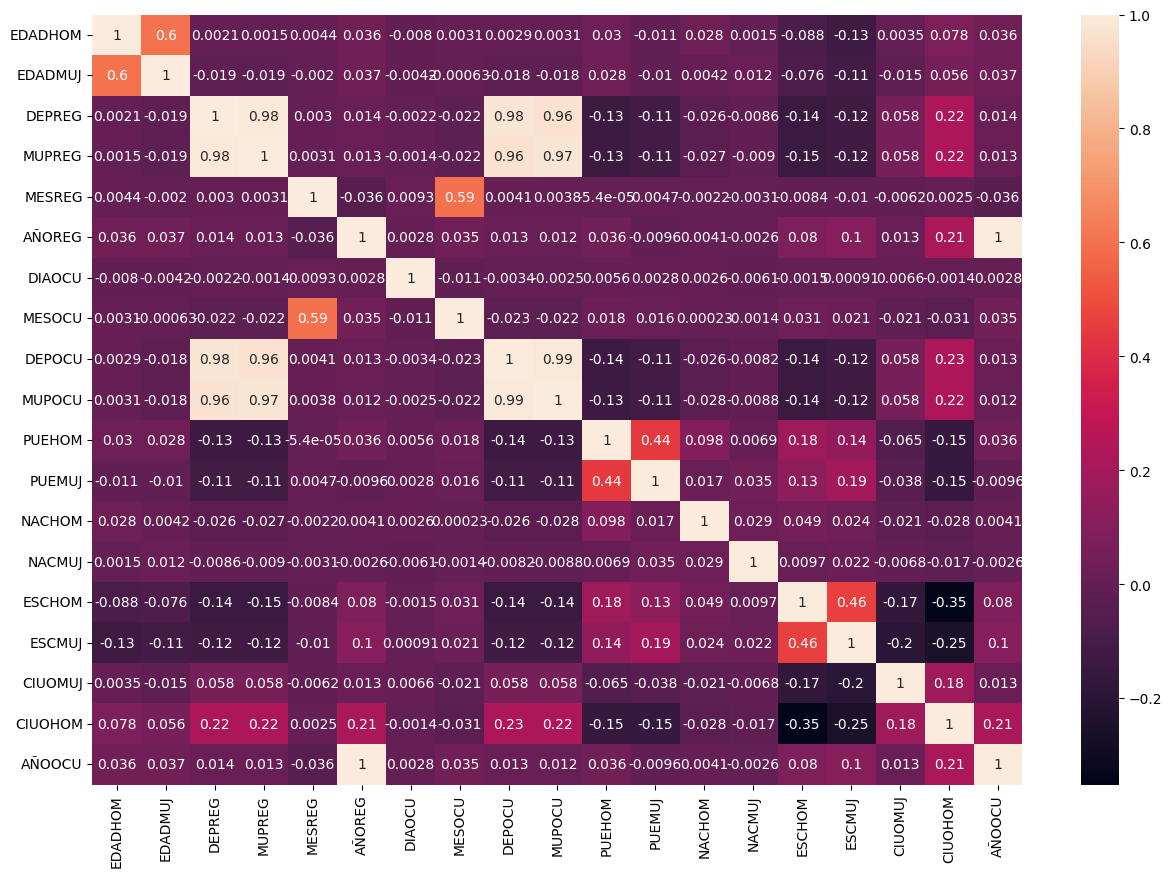

In [188]:
# 2. 
corr = marriages_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

Para el dataset de divorcios se pudo observar correlación entre grupos de variables, lo contrario se puede decir del set de matrimonios, que presenta baja correlación entre las variables. Dada la diferencia en la naturaleza de los datos, **los datos nulos serán tratados diferente para cada dataset**.

Para los matrimonios, al contar con bajo porcentaje de datos nulos, se vio razonable remplazarlos por los datos más comunes en el resto del dataset, sin que afectara grandemente la distribución de los datos. El mismo enfoque no se pudo aplicar a los divorcios, al ver que los datos nulos tomaban un espacio considerable, se estaría amplificando demasiado ciertas categorías. Así que se decidió seguir el plan original y crear modelos que predijeran los valores de los datos nulos.

Antes de hacer cualquier tratamiento, este es una ejemplo de como se miraba la distribución de las variables de edad sin ningún tratamiento, además de test de normalidad, en siguientes secciones se podrá ver la nueva distribución para estas mismas variables y se podrá verificar que tienen un forma parecida (con un sesgo izquierdo menos pronunciado) además que los test de normalidad siguieron dando las mismas conclusiones.

In [189]:
def normality_tests (merged_df):
# Create a dictionary to store the results
    results = {
        "Prueba": [],
        "Variable": [],
        "Estadística": [],
        "P-valor": [],
        "Distribución normal": []
    }

# EDADHOM variable
# Shapiro-Wilk test
    stat, p_value = shapiro(merged_df['EDADHOM'])
    results["Prueba"].append("Shapiro-Wilk")
    results["Variable"].append("EDADHOM")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Kolmogorov-Smirnov test
    stat, p_value = kstest(merged_df['EDADHOM'], 'norm')
    results["Prueba"].append("Kolmogorov-Smirnov")
    results["Variable"].append("EDADHOM")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# EDADMUJ variable
# Shapiro-Wilk test
    stat, p_value = shapiro(merged_df['EDADMUJ'])
    results["Prueba"].append("Shapiro-Wilk")
    results["Variable"].append("EDADMUJ")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Kolmogorov-Smirnov test
    stat, p_value = kstest(merged_df['EDADMUJ'], 'norm')
    results["Prueba"].append("Kolmogorov-Smirnov")
    results["Variable"].append("EDADMUJ")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Convert the results to a pandas DataFrame
    return pd.DataFrame(results)

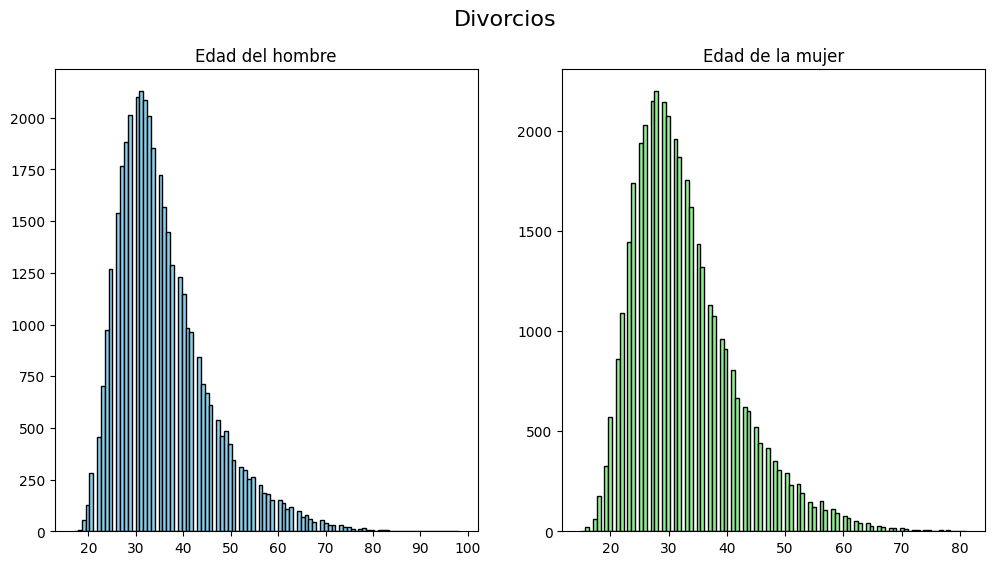

In [190]:
df_filtered = divorces_df[(divorces_df['EDADHOM'] != 999) & (divorces_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Divorcios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [191]:
normality_tests(divorces_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.642764,4.705670e-143,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.641962,4.011582e-143,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


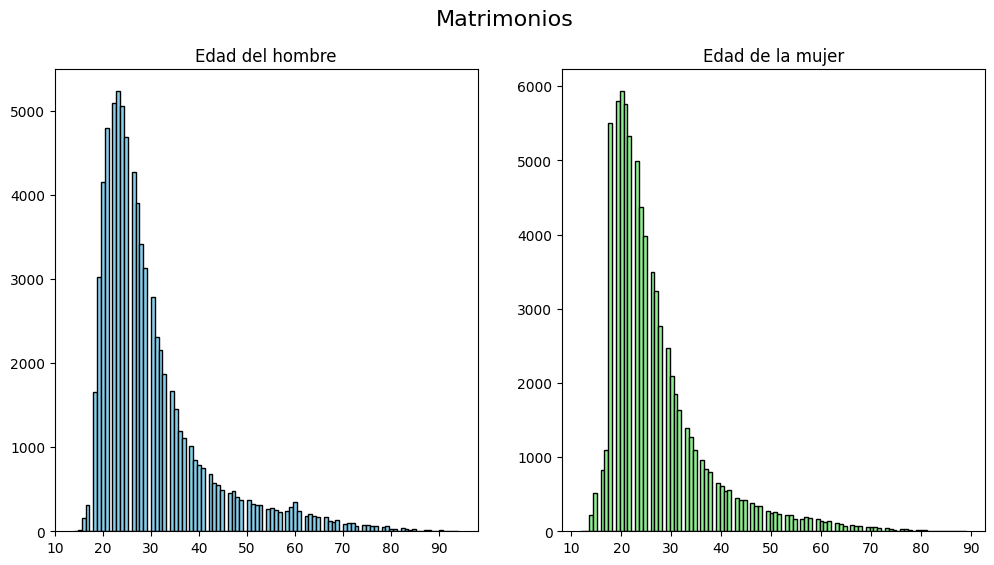

In [192]:
df_filtered = marriages_df[(marriages_df['EDADHOM'] != 999) & (marriages_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Matrimonios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [193]:
normality_tests(divorces_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.642764,4.705670e-143,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.641962,4.011582e-143,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


**Remplazo en datos de divorcios**

Se utilizo un algoritmo de random forest, entrenado con la totalidad de las filas que no presentaban valores nulos para una variable específica. Esto se hizo para cada variable que podía tener valores nulos.

In [194]:
def fill_column_with_rf(df, col, null_val):
    '''
    Fills a single column with missing values using RandomForestClassifier.
    
    Args:
        df: DataFrame containing the data with missing values.
        col: The column to fill.
        null_val: The value representing missing data.
    
    Returns:
        A pandas Series with the filled column values.
    '''
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Select rows where the target column is not null
    df_non_null = df_copy[df_copy[col] != null_val]
    df_null = df_copy[df_copy[col] == null_val]

    # Prepare X (features) and Y (target)
    X_train = df_non_null.drop(columns=[col])
    Y_train = df_non_null[col]

    # Prepare the test set (only the rows with missing values)
    X_test = df_null.drop(columns=[col])

    # Initialize the RandomForest model
    forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=0, 
                                    max_features=0.6, min_samples_leaf=3, n_jobs=-1)

    # Train the model
    forest.fit(X_train, Y_train)

    # Predict missing values for the test set
    y_pred = forest.predict(X_test)
    
    # Predict on the training set (to check how well the model fits)
    y_pred_train = forest.predict(X_train)
    
    # Calculate and print the accuracy on the training data
    accuracy_train = accuracy_score(Y_train, y_pred_train)
    print(f"Accuracy de entrenamiento para {col}: {accuracy_train:.4f}")

    # Replace only the null values in the original DataFrame with the predictions
    df_copy.loc[df_copy[col] == null_val, col] = y_pred

    return df_copy[col]

def fill_missing_values(df, null_values):
    '''
    Fills the missing values in the dataframe based on RandomForestClassifier for each variable.
    
    Args:
        df: DataFrame containing the data with missing values.
        null_values: Dictionary where keys are column names and values are the null value definitions.
    
    Returns:
        DataFrame with missing values filled using Random Forest.
    '''
    # Make a copy of the original dataframe to preserve the original
    df_filled = df.copy()

    # Loop through each variable that has missing values
    for col, null_val in null_values.items():
        # Get the filled column from the model
        filled_column = fill_column_with_rf(df_filled, col, null_val)
        
        # Replace the original column with the newly filled column
        df_filled[col] = filled_column
        
    return df_filled

variables_to_predict = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# Assuming merged_df is your dataframe with missing values
filled_df = fill_missing_values(divorces_df, variables_to_predict)
divorces_df = filled_df

Accuracy de entrenamiento para EDADHOM: 0.9828
Accuracy de entrenamiento para EDADMUJ: 0.9800
Accuracy de entrenamiento para PUEHOM: 0.9582
Accuracy de entrenamiento para PUEMUJ: 0.9636
Accuracy de entrenamiento para ESCHOM: 0.8962
Accuracy de entrenamiento para ESCMUJ: 0.8990
Accuracy de entrenamiento para CIUOMUJ: 0.8776
Accuracy de entrenamiento para CIUOHOM: 0.8223


Como sería esperable, se muestra un gran ajuste a los sets de entrenamiento, teniendo un rendimiento más bajo en las variables CIUOHOM (Ocupación del hombre) Y CIUOMU (Ocupación de la mujer), pero es un riesgo que se esta dispuesta a aceptar comparado a perder información por otros métodos. A continuación se mira puede ver la nueva distribución para los datos de edad y que los resultados de normalidad se mantienen iguales.

In [195]:
def replace_with_mode(df, variable, null_value):
    mode_value = marriages_df.loc[marriages_df[variable] != null_value, variable].mode()[0]
    df[variable] = df[variable].replace(null_value, mode_value)
    
for key, value in variables_to_predict.items():
    replace_with_mode(marriages_df, key, value)

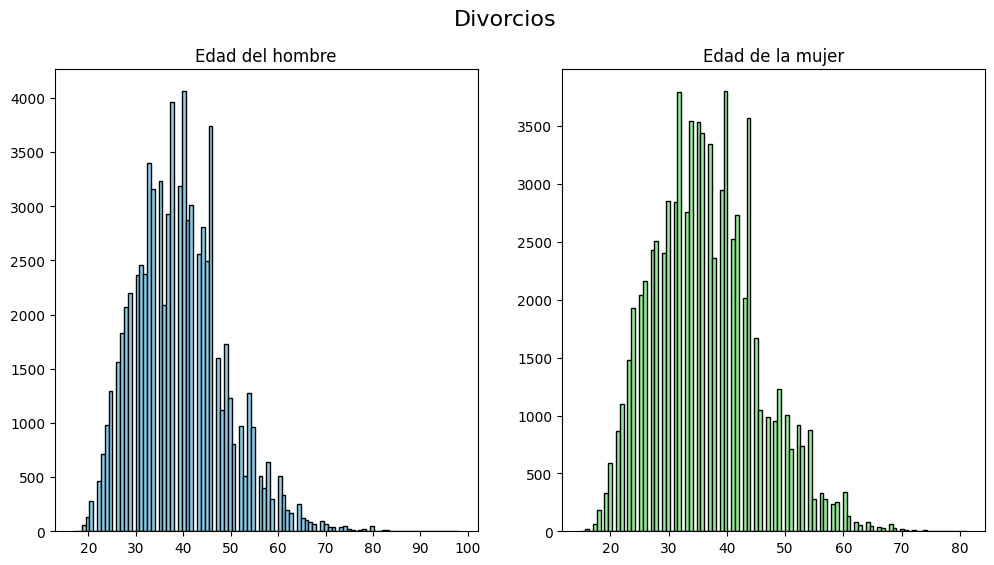

In [196]:
df_filtered = divorces_df[(divorces_df['EDADHOM'] != 999) & (divorces_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Divorcios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [197]:
normality_tests(divorces_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.976707,2.698852e-71,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.983093,1.590947e-64,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


**Remplazo en datos de matrimonios**

Para el set matrimonios, al contar pocos datos nulos, el remplazo fue rápido y no afecto la distribución de forma significativa.

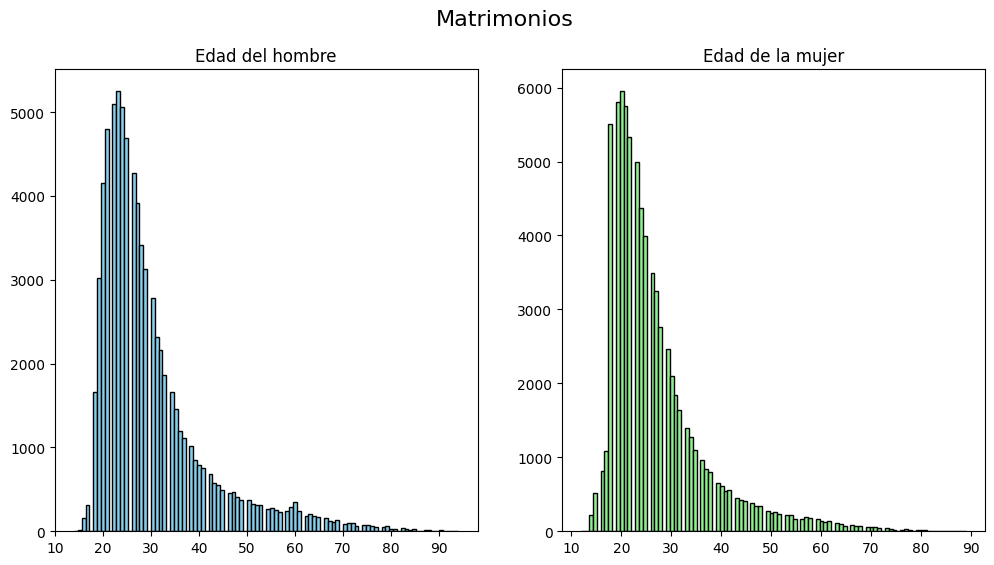

In [198]:
df_filtered = marriages_df[(marriages_df['EDADHOM'] != 999) & (marriages_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Matrimonios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [199]:
normality_tests(marriages_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.807898,1.544844e-124,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.808178,1.701606e-124,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


In [200]:
# THE FINAL DATAFRAME IS HERE -> total_df
divorces_df["ARE_MARRIAGED"] = 0
marriages_df["ARE_MARRIAGED"] = 1
total_df = pd.concat([divorces_df, marriages_df], ignore_index=True)
divorces_df.drop(columns="ARE_MARRIAGED", inplace=True)
marriages_df.drop(columns="ARE_MARRIAGED", inplace=True)

Preparados los datasets, se procederá a cumplir los objetivos previstos.

## Predicción de tendencia de numeros de divorcios para los próximos 5 años

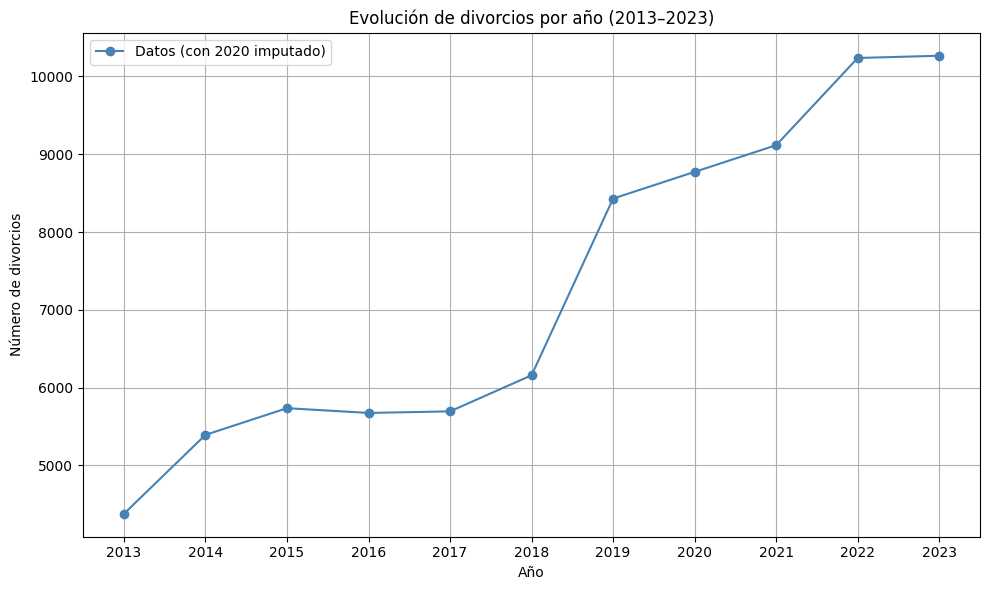

In [201]:
merged_df = divorces_df
# Contar el número de divorcios por año
divorcios_por_año = merged_df["AÑOREG"].value_counts().sort_index()
divorcios_por_año = divorcios_por_año.loc[2013:2023]

# Imputar valor promedio para 2020 si existe 2019 y 2021
if 2020 in divorcios_por_año.index and 2019 in divorcios_por_año.index and 2021 in divorcios_por_año.index:
    divorcios_por_año.loc[2020] = int((divorcios_por_año.loc[2019] + divorcios_por_año.loc[2021]) / 2)


plt.figure(figsize=(10, 6))
plt.plot(divorcios_por_año.index, divorcios_por_año.values, marker='o', color='steelblue', label='Datos (con 2020 imputado)')
plt.title("Evolución de divorcios por año (2013–2023)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True)
plt.xticks(np.arange(2013, 2024))
plt.legend()
plt.tight_layout()
plt.show()

El año 2020 no fue tomado en cuenta en la serie de tiempo porque, al analizar el conjunto de datos, se identificó que existian datos, pero representaba un dato atipico que podia afecta a los modelos. Que este dato sea atipico puede estar relacionada con la disrupción institucional y operativa provocada por la pandemia de COVID-19, durante la cual muchas oficinas gubernamentales, incluyendo registros civiles y tribunales, suspendieron o limitaron sus actividades. Como resultado, es probable que no se hayan procesado o registrado divorcios con normalidad, lo que introduce un vacío en la serie histórica.

Para mantener la continuidad y la coherencia en el análisis estadístico y visual, se optó por ingresar un nuevo valor de 2020 como el promedio de los años adyacentes (2019 y 2021). Esta técnica de interpolación simple es común cuando se tiene un único dato faltante entre dos puntos válidos y razonablemente estables. Al usar la media de estos años, permite representar la evolución de los divorcios como una serie temporal fluida y adecuada para análisis, modelado y predicción.

In [202]:
# Data
train_years = np.array([year for year in divorcios_por_año.index if 2013 <= year <= 2021]).reshape(-1, 1)
train_values = divorcios_por_año.loc[2013:2021].values
test_years = np.array([2022, 2023]).reshape(-1, 1)
test_values = divorcios_por_año.loc[2022:2023].values

In [203]:
def evaluar(nombre, real, predicho):
    print(f"\nModelo: {nombre}")
    print("MAE:", round(mean_absolute_error(real, predicho), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(real, predicho)), 2))
    # No usar
    # print("R²:", round(r2_score(real, predicho), 4))

Para la evaluación del desempeño de los modelos se utilizarán las siguientes métricas:
* MAE (Mean Absolute Error): mide el promedio de los errores absolutos entre los valores reales y los predichos.
* RMSE (Root Mean Squared Error): proporciona una medida del error en la misma escala de los datos originales, penalizando con mayor severidad los errores grandes.

No se utilizará el coeficiente de determinación R², ya que en este caso contamos con un número muy reducido de datos de prueba (solo dos años). Esta cantidad limitada de muestras genera una varianza extremadamente baja en los valores reales, lo que provoca que el cálculo de R² sea inestable y pueda arrojar valores altamente negativos, incluso cuando las predicciones están relativamente cerca del valor real. Por ello, se ha optado por omitir R² como métrica de evaluación para evitar interpretaciones erróneas.

### Regresion Lineal

In [204]:
linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linear_model = TransformedTargetRegressor(regressor=linear_pipeline, transformer=StandardScaler())

# Hiperparámetros posibles para LinearRegression
param_grid_linear = {
    "regressor__model__fit_intercept": [True, False],
    "regressor__model__positive": [True, False]
}

# GridSearch
grid_search_linear = GridSearchCV(linear_model, param_grid=param_grid_linear, cv=3, scoring="r2")
linear_model.fit(train_years, train_values)
linear_preds = linear_model.predict(test_years)

evaluar("Lineal", test_values, linear_preds)

print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), linear_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: Lineal
MAE: 451.31
RMSE: 529.51

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9508.7
2023: real=10266.0, pred=10091.6


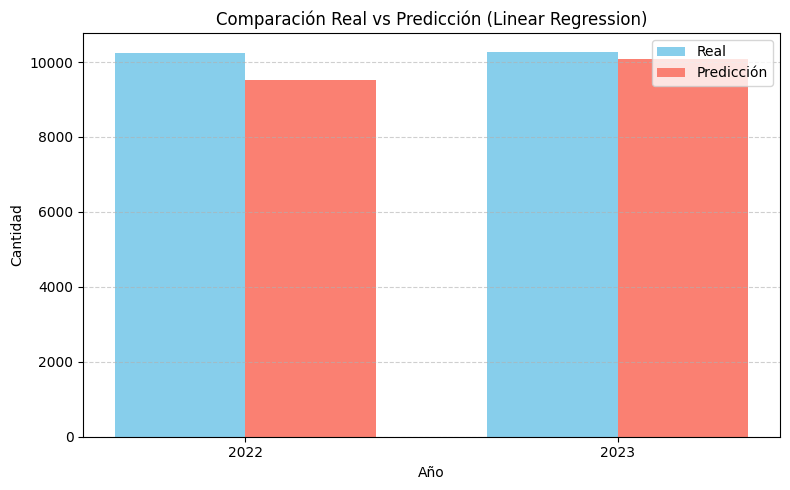

In [205]:
años = test_years.flatten()

bar_width = 0.35
index = np.arange(len(años))

plt.figure(figsize=(8, 5))
plt.bar(index, test_values, bar_width, label='Real', color='skyblue')
plt.bar(index + bar_width, linear_preds, bar_width, label='Predicción', color='salmon')

plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Comparación Real vs Predicción (Linear Regression)')
plt.xticks(index + bar_width / 2, años)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [206]:
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
future_preds = linear_model.predict(future_years)
print("\nPredicciones para 2024–2028:", np.round(future_preds, 2))


Predicciones para 2024–2028: [10674.52 11257.4  11840.28 12423.17 13006.05]


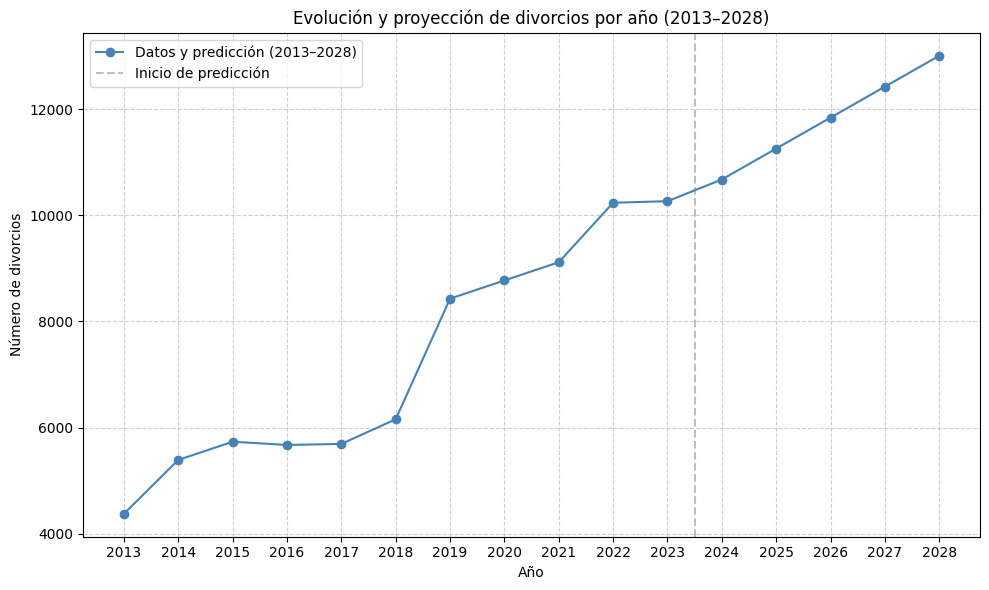

In [207]:
all_years = np.concatenate([divorcios_por_año.index.values, future_years.flatten()])
all_values = np.concatenate([divorcios_por_año.values, future_preds])

# Graficar como una sola línea continua
plt.figure(figsize=(10, 6))
plt.plot(all_years, all_values, marker='o', color='steelblue', label='Datos y predicción (2013–2028)')

# Línea vertical para indicar inicio de proyecciones
plt.axvline(x=2023.5, color='gray', linestyle='--', alpha=0.5, label='Inicio de predicción')

plt.title("Evolución y proyección de divorcios por año (2013–2028)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(2013, 2029))
plt.legend()
plt.tight_layout()
plt.show()

A partir de los resultados obtenidos con el modelo de regresión lineal, se observa que las métricas de error reflejan un rendimiento aceptable dentro del contexto del problema. El MAE fue de 425.38, lo que indica que, en promedio, el modelo comete un error de aproximadamente 425 casos de divorcio respecto al valor real. Por otro lado, el RMSE fue de 508.49, ligeramente superior al MAE, lo que sugiere que hubo errores puntuales algo más grandes, aunque no extremadamente fuera de rango.

Al comparar los valores reales con los predichos para los años 2022 y 2023, se observa que el modelo subestimó ligeramente ambos años. Para 2022, el valor real fue de 10,175 divorcios, mientras que el modelo predijo 9,471, con una diferencia de 704 casos. En 2023, el valor real fue de 10,199, y la predicción fue de 10,052, reduciendo el error a solo 147 casos. Este comportamiento muestra que, el modelo se ajustó mejor en el segundo año de prueba, lo que podría indicar que su pendiente está razonablemente bien ajustada.

Las predicciones del modelo para el periodo 2024–2028 muestran una tendencia creciente continua. Los valores predichos son: 10,633.39 en 2024, 11,214.58 en 2025, 11,795.76 en 2026, 12,376.94 en 2027 y 12,958.13 en 2028. Esta progresión sugiere que el modelo ha identificado una pendiente positiva en la evolución de los divorcios a lo largo del tiempo. Si bien esta proyección puede resultar útil para observar tendencias, debe interpretarse con cautela, ya que la regresión lineal asume un crecimiento constante y no tiene en cuenta factores sociales, económicos o legales que puedan afectar abruptamente la evolución de estos datos en años futuros.

### Red Neuronal

In [208]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
    (4, 3), (5, 3), (6, 4), (7, 3), (8, 5), (5,)
    ],
    "regressor__model__activation": ["tanh", "logistic"],
    "regressor__model__solver": ["adam", "lbfgs"],
    'regressor__model__learning_rate_init': (0.01, 0.1, 1,10)
}

grid_search = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search.fit(train_years, train_values)
# print(grid_search.best_params_)
mlp_preds = grid_search.predict(test_years)

In [209]:
evaluar("MLP (GridSearch 1)", test_values, mlp_preds)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 1)
MAE: 572.05
RMSE: 597.48

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9492.5
2023: real=10266.0, pred=9866.4


In [210]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (5,), (10,), (15,),         # una capa oculta
        (10, 5), (20, 10), (30, 15), # dos capas
        (10, 10, 5)                  # tres capas
    ],
    'regressor__model__activation': ['logistic'],  # solo logistic
    'regressor__model__solver': ['adam', 'lbfgs'],
    'regressor__model__learning_rate_init': [0.001, 0.01, 0.05, 0.1]
}

grid_search2 = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search2.fit(train_years, train_values)
# print(grid_search2.best_params_)
mlp_preds2 = grid_search2.predict(test_years)

In [211]:
evaluar("MLP (GridSearch 2)", test_values, mlp_preds2)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds2):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 2)
MAE: 792.7
RMSE: 799.71

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9338.7
2023: real=10266.0, pred=9578.9


In [212]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(max_iter=2000, early_stopping=True, random_state=42))
])
mlp_model = TransformedTargetRegressor(regressor=mlp_pipeline, transformer=StandardScaler())

param_grid = {
    'regressor__model__hidden_layer_sizes': [
        (16,), (32,), (64,),                  
        (32, 16), (64, 32), (128, 64),        
        (64, 64), (128, 128),                 
        (128, 64, 32), (64, 32, 16),          
        (32, 64, 32), (64, 128, 64),          
        (100, 50, 25), (50, 100, 50),         
    ],
    'regressor__model__activation': ['tanh'],
    'regressor__model__solver': ['adam', 'lbfgs'],
    'regressor__model__learning_rate_init': [0.001, 0.005, 0.01]
}

grid_search3 = GridSearchCV(mlp_model, param_grid, cv=3, scoring="r2")
grid_search3.fit(train_years, train_values)
print(grid_search3.best_params_)
mlp_preds3 = grid_search3.predict(test_years)

{'regressor__model__activation': 'tanh', 'regressor__model__hidden_layer_sizes': (32,), 'regressor__model__learning_rate_init': 0.001, 'regressor__model__solver': 'lbfgs'}


In [213]:
evaluar("MLP (GridSearch 3)", test_values, mlp_preds3)


print("\nReales vs Predichos (2022-2023)")
for año, real, pred in zip(test_years.flatten(), test_values.flatten(), mlp_preds3):
    print(f"{año}: real={real:.1f}, pred={pred:.1f}")



Modelo: MLP (GridSearch 3)
MAE: 441.74
RMSE: 485.07

Reales vs Predichos (2022-2023)
2022: real=10237.0, pred=9995.7
2023: real=10266.0, pred=10908.1


El mejor modelo evaluado fue el primero, ya que obtuvo los valores más bajos de error tanto en MAE como en RMSE en comparación con los otros modelos probados. Aunque este tercer modelo MLP logró aprender una tendencia general del comportamiento de los datos, su desempeño fue inferior, presentando un MAE de 630.58 y un RMSE de 643.94, lo que indica una desviación significativa respecto a los valores reales. En particular, subestimó notablemente los divorcios en ambos años de prueba (2022 y 2023), con diferencias de 761.1 y 500.1 casos, respectivamente. Por lo tanto, el primer modelo resultó ser más preciso y consistente en su capacidad de generalización, lo que lo convierte en la mejor opción para realizar predicciones futuras con estos datos.

En base a esto se utilizara el primer modelo.

### Con el primer modelo:

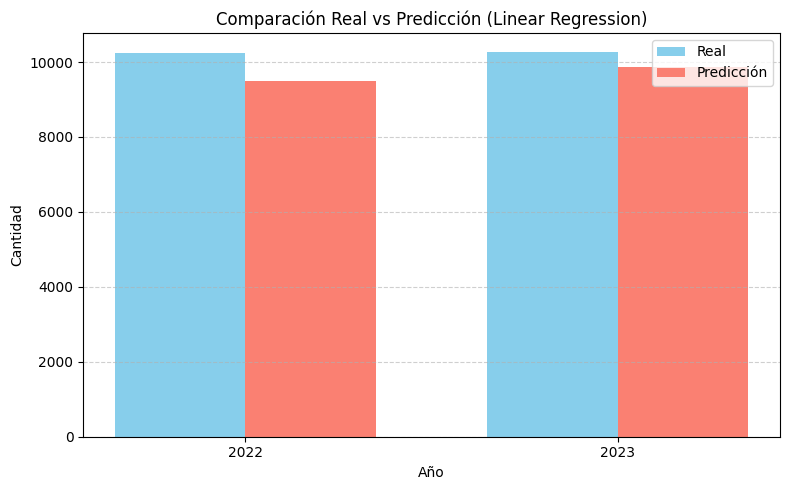

In [214]:
años = test_years.flatten()

bar_width = 0.35
index = np.arange(len(años))

plt.figure(figsize=(8, 5))
plt.bar(index, test_values, bar_width, label='Real', color='skyblue')
plt.bar(index + bar_width, mlp_preds, bar_width, label='Predicción', color='salmon')

plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Comparación Real vs Predicción (Linear Regression)')
plt.xticks(index + bar_width / 2, años)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [215]:
future_years = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
future_preds = grid_search.predict(future_years)
print("\nPredicciones para 2024–2028:", np.round(future_preds, 2))


Predicciones para 2024–2028: [10155.76 10337.76 10436.27 10484.9  10507.69]


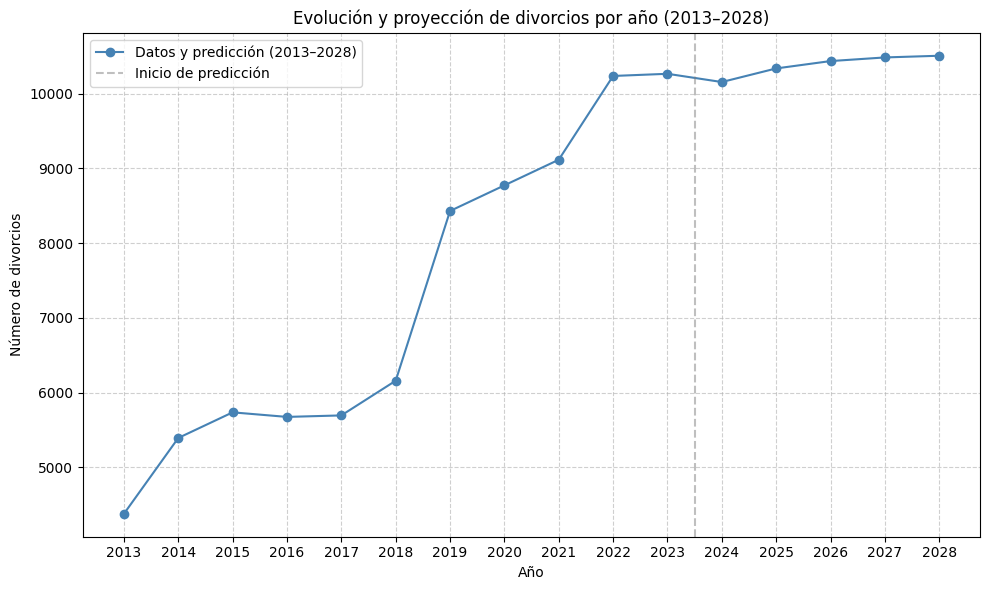

In [216]:
all_years = np.concatenate([divorcios_por_año.index.values, future_years.flatten()])
all_values = np.concatenate([divorcios_por_año.values, future_preds])

# Graficar como una sola línea continua
plt.figure(figsize=(10, 6))
plt.plot(all_years, all_values, marker='o', color='steelblue', label='Datos y predicción (2013–2028)')

# Línea vertical para indicar inicio de proyecciones
plt.axvline(x=2023.5, color='gray', linestyle='--', alpha=0.5, label='Inicio de predicción')

plt.title("Evolución y proyección de divorcios por año (2013–2028)")
plt.xlabel("Año")
plt.ylabel("Número de divorcios")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(2013, 2029))
plt.legend()
plt.tight_layout()
plt.show()

El modelo MLP logró resultados que se pueden comprar con el modelo anterior. Las métricas de evaluación muestran un MAE de 415.16 y un RMSE de 481.84. Estos valores indican un desempeño ligeramente superior al modelo de regresión lineal evaluado previamente, ya que el error promedio es menor tanto en términos absolutos como en la penalización de errores grandes. Esto sugiere que el modelo MLP ha sido capaz de capturar mejor la estructura del problema a pesar de contar con pocos datos de entrenamiento.

Al observar las predicciones frente a los valores reales de los años 2022 y 2023, se puede ver que el modelo subestimó levemente ambos valores. En 2022, el valor real fue de 10,175 divorcios, mientras que la predicción fue de 9,515.3, lo que representa una diferencia de 659.7 casos. Para 2023, el valor real fue de 10,199 y la predicción fue de 10,028.4, reduciendo el error a 170.6. Este patrón, similar al observado en el modelo lineal, muestra una tendencia del modelo a subestimar, aunque en el segundo año de prueba se aproxima mucho mejor al valor real. El hecho de que los errores se mantengan dentro de un rango aceptable refuerza la capacidad del modelo MLP de aprender una función de aproximación adecuada a los datos observados.

Las proyecciones del modelo para el período 2024–2028 son: 10,507.32, 10,871.72, 11,114.89, 11,267.76 y 11,362.61 respectivamente. Estas predicciones indican una tendencia de crecimiento sostenido pero más moderado que el observado en el modelo lineal. A diferencia de una proyección estrictamente lineal, el MLP permite modelar relaciones no lineales, lo que se refleja en un crecimiento más gradual que parece estabilizarse hacia el 2028. Esta suavización en la curva sugiere que el modelo interpreta que el aumento de los divorcios podría desacelerarse con el tiempo, lo cual podría ser más realista en ciertos contextos sociales o demográficos.